# Project 3: Web APIs & Classification - PART B

## Problem Statement

Reddit is a platform of over a million communities more commonly known as "subreddits". Each subreddit covers a specific topic. Subreddits work like a forum where users can come together and participate in an online discussion relative to the subreddit.<br>

In this project, we will be building a classifier that uses words to identify subreddits. The two subreddits we will distinguish between are <b>r/BMW</b> and <b>r/teslamotors</b>.<br>

It is a general rule on Reddit that posts made must somewhat pertain to the subreddit it is being posted in. Users may find it difficult to distinguish which subreddit would be more appropriate for them to create a post in. With a classifier that identifies the subreddit based on keywords, it may be easier for the user to identify which subreddit it is more appropriate to make their posting in.<br>

## <b>Contents</b>
<b>Part A:</b>
1. Data Collection


<b>Part B:</b><br>
1. Data Cleaning
2. Pre-processing & EDA
3. Modelling
4. Evaluation & Conceptual Understanding
5. Conclusion & Recommendations

### <b>IMPORTS:</b>

In [1]:
import numpy as np
import pandas as pd

import wordcloud
from wordcloud import WordCloud

import nltk
import regex as re
from bs4 import BeautifulSoup             
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.pipeline import Pipeline

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV)

from sklearn.feature_extraction.text import (CountVectorizer, 
                                             TfidfVectorizer)

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import (GradientBoostingClassifier,
                              AdaBoostClassifier,
                              RandomForestClassifier,
                              VotingClassifier,
                              BaggingClassifier)

## <b>1. Data Cleaning & EDA</b>

In [2]:
#Reading in files generated from scrape:
bmw1 = pd.read_csv('./datasets/bmw1.csv', error_bad_lines=False)
bmw2 = pd.read_csv('./datasets/bmw2.csv', error_bad_lines=False)
bmw3 = pd.read_csv('./datasets/bmw3.csv', error_bad_lines=False)
tsla1 = pd.read_csv('./datasets/tsla1.csv', error_bad_lines=False)
tsla2 = pd.read_csv('./datasets/tsla2.csv', error_bad_lines=False)
tsla3 = pd.read_csv('./datasets/tsla3.csv', error_bad_lines=False)

In [3]:
#checking shape to ensure no. of columns are the same:
print(bmw1.shape)
print(bmw2.shape)
print(bmw3.shape)
print(tsla1.shape)
print(tsla2.shape)
print(tsla3.shape)

(600, 114)
(600, 115)
(602, 115)
(600, 114)
(600, 115)
(403, 115)


In [4]:
#checking for difference in columns betweem bmw3 and bmw1:
set(bmw3) - set(bmw1)

{'poll_data'}

In [5]:
#checking for difference in columns betweem tsla3 and tsla1:
set(tsla3) - set(tsla1)

{'poll_data'}

In [6]:
#dropping the extra columns from bmw2, bmw3, tsla2, tsla 3:
bmw2.drop(columns=['poll_data'], inplace=True)
bmw3.drop(columns=['poll_data'], inplace=True)
tsla2.drop(columns=['poll_data'], inplace=True)
tsla3.drop(columns=['poll_data'], inplace=True)

In [7]:
#checking shape to ensure no. of columns are the same:
print(bmw1.shape)
print(bmw2.shape)
print(bmw3.shape)
print(tsla1.shape)
print(tsla2.shape)
print(tsla3.shape)

(600, 114)
(600, 114)
(602, 114)
(600, 114)
(600, 114)
(403, 114)


### Creating & cleaning dataframe for r/BMW:

In [8]:
#combining bmw dfs:
bmwdf = pd.concat([bmw1, bmw2, bmw3], axis = 0, ignore_index = True)

#checking shape after combination:
print("No. of Rows & Columns for BMW: ", bmwdf.shape) 

#checking null values of selftext & title columns:
print("Null Vals in 'selftext': ", bmwdf['selftext'].isnull().sum())
print("Null Vals in 'title': ", bmwdf['title'].isnull().sum())

No. of Rows & Columns for BMW:  (1802, 114)
Null Vals in 'selftext':  1540
Null Vals in 'title':  0


In [9]:
#replacing nulls with an empty string
bmwdf['selftext'].replace(np.nan, '', inplace=True)

#checking null values of selftext after replacement:
print("Null Vals in 'selftext': ", bmwdf['selftext'].isnull().sum())

Null Vals in 'selftext':  0


In [10]:
#adding a combined column of selftext and title
bmwdf['selftext_title'] = bmwdf['selftext'] + " " + bmwdf['title']

In [11]:
#no of rows after dropping duplicates:
print("No of rows before dropping duplicates: ", bmwdf.shape)

#dropping duplicates on new combined column:
bmwdf.drop_duplicates(subset='selftext_title', inplace=True)

#no of rows after dropping duplicates:
print("No of rows after dropping duplicates: ", bmwdf.shape)


No of rows before dropping duplicates:  (1802, 115)
No of rows after dropping duplicates:  (1198, 115)


### Creating & cleaning dataframe for r/teslamotors: 

In [12]:
#combining bmw dfs:
tsladf = pd.concat([tsla1, tsla2, tsla3], axis = 0, ignore_index = True)

#checking shape after combination:
print("No. of Rows & Columns for TSLA: ", tsladf.shape) 

#checking null values of selftext & title columns:
print("Null Vals in 'selftext': ", tsladf['selftext'].isnull().sum())
print("Null Vals in 'title': ", tsladf['title'].isnull().sum())

No. of Rows & Columns for TSLA:  (1603, 114)
Null Vals in 'selftext':  1112
Null Vals in 'title':  0


In [13]:
#replacing nulls with an empty string
tsladf['selftext'].replace(np.nan, '', inplace=True)

#checking null values of selftext after replacement:
print("Null Vals in 'selftext': ", tsladf['selftext'].isnull().sum())

Null Vals in 'selftext':  0


In [14]:
#adding a combined column of selftext and title
tsladf['selftext_title'] = tsladf['selftext'] + " " + tsladf['title']

In [15]:
#no of rows after dropping duplicates:
print("No of rows before dropping duplicates: ", tsladf.shape)

#dropping duplicates on new combined column:
tsladf.drop_duplicates(subset='selftext_title', inplace=True)

#no of rows after dropping duplicates:
print("No of rows after dropping duplicates: ", tsladf.shape)

No of rows before dropping duplicates:  (1603, 115)
No of rows after dropping duplicates:  (1149, 115)


### Combining BMW & teslamotors dataframes:

<b>Joining BMW & teslamotors dataframes: </b>

In [16]:
df = pd.concat([bmwdf, tsladf], axis=0, ignore_index=True)

In [17]:
df.shape #1198 rows for BMW, 1149 for TSLA

(2347, 115)

In [18]:
#selecting only relevant columns
df = df[['subreddit','selftext_title']]

<b> Assigning binary values to the 'subreddit' column: </b> <br>
    0: BMW <br>
    1: teslamotors

In [19]:
df['subreddit'] = df['subreddit'].map({
    'BMW': 0, 
    'teslamotors': 1})

In [20]:
#checking if the binary values have been assigned correctly
#first 5 rows should be 0, last 5 rows should be 1
df.head(2347)

,subreddit,selftext_title
0,0,"If you're gonna do it, that's how it's done"
1,0,"When hurricane Matthew is coming, and you don..."
2,0,What is this weird green arrow light that cam...
3,0,This is where they are headed
4,0,How to scare this sub properly
...,...,...
2342,1,When model 3 and eventually model y were relea...
2343,1,Edmunds Tested: Electric Car Range and Consum...
2344,1,"Model 3 pricing has now increased £3,000 to r..."
2345,1,In less than a month China has restricted Tesl...


## <b>2. Pre-processing & EDA</b>

<b> Creating a manual list of words to be excluded: </b>

In [21]:
words_to_remove = ['www','reddit','com','cars', 'car','r',
                 'beemer','bimmer','bmw','tesla','tsla',
                  'one','new','first','year','f','finally','got']

<b> Creating a text processing function: </b>

In [22]:
def clean_text(raw_text, words_to_exclude):
    #this function converts a raw review to a string of words
    #input: raw_text: raw text to be reviewed (a single string)
    #output: a single string (a preprocessed/reviewed) text.

    #1) Removing any HTML tags:
    review_text = BeautifulSoup(raw_text).get_text()
    
    #2) Removing non alphanumeric & \n
    review_text = re.sub("[\W\\n\_\d]", " ", review_text)

    #3) Converting stopwords to a set since searching a set is faster 
    #   than searching a string
    stops = set(stopwords.words('english') + words_to_exclude)
    
    #4) removing stopwords & lemmatizing
    lemmatizer = WordNetLemmatizer()
    
    filtered_words = [lemmatizer.lemmatize(w) for 
                      w in review_text.lower().split() if 
                      w not in stops]

    #5) joining words back to one string
    filtered_words = " ".join(filtered_words)
    
    return filtered_words

<b>Applying the above function to a new column ('cleaned') in the combined dataframe:</b>

In [23]:
#cleans text in 'selftext_title' and inputs cleaned text into col: 'cleaned'
df['cleaned'] = df.apply(lambda row: 
                         clean_text(
                             row['selftext_title'],
                             words_to_remove), axis=1)

In [24]:
df['cleaned'][20]

'saw sweet e riding la decided take quick roller hopefully owner somehow see'

In [25]:
df

,subreddit,selftext_title,cleaned
0,0,"If you're gonna do it, that's how it's done",gonna done
1,0,"When hurricane Matthew is coming, and you don...",hurricane matthew coming garage e
2,0,What is this weird green arrow light that cam...,weird green arrow light came concerned
3,0,This is where they are headed,headed
4,0,How to scare this sub properly,scare sub properly
...,...,...,...
2342,1,When model 3 and eventually model y were relea...,model eventually model released bit insult mod...
2343,1,Edmunds Tested: Electric Car Range and Consum...,edmunds tested electric range consumption
2344,1,"Model 3 pricing has now increased £3,000 to r...",model pricing increased reflect change uk plug...
2345,1,In less than a month China has restricted Tesl...,le month china restricted use http wsj article...


### WORDCLOUDS:

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

#creating a function to plot word clouds:
def plot_cloud(wordcloud):
    #setting figure size
    plt.figure(figsize=(40, 30))
    #displaying image
    plt.imshow(wordcloud) 
    #axes details off
    plt.axis("off");

In [27]:
#plotting on cleaned text for bmw dataframe
bmwdf['cleaned'] = bmwdf.apply(lambda row: 
                               clean_text(row['selftext_title'], 
                                          words_to_remove), axis=1)

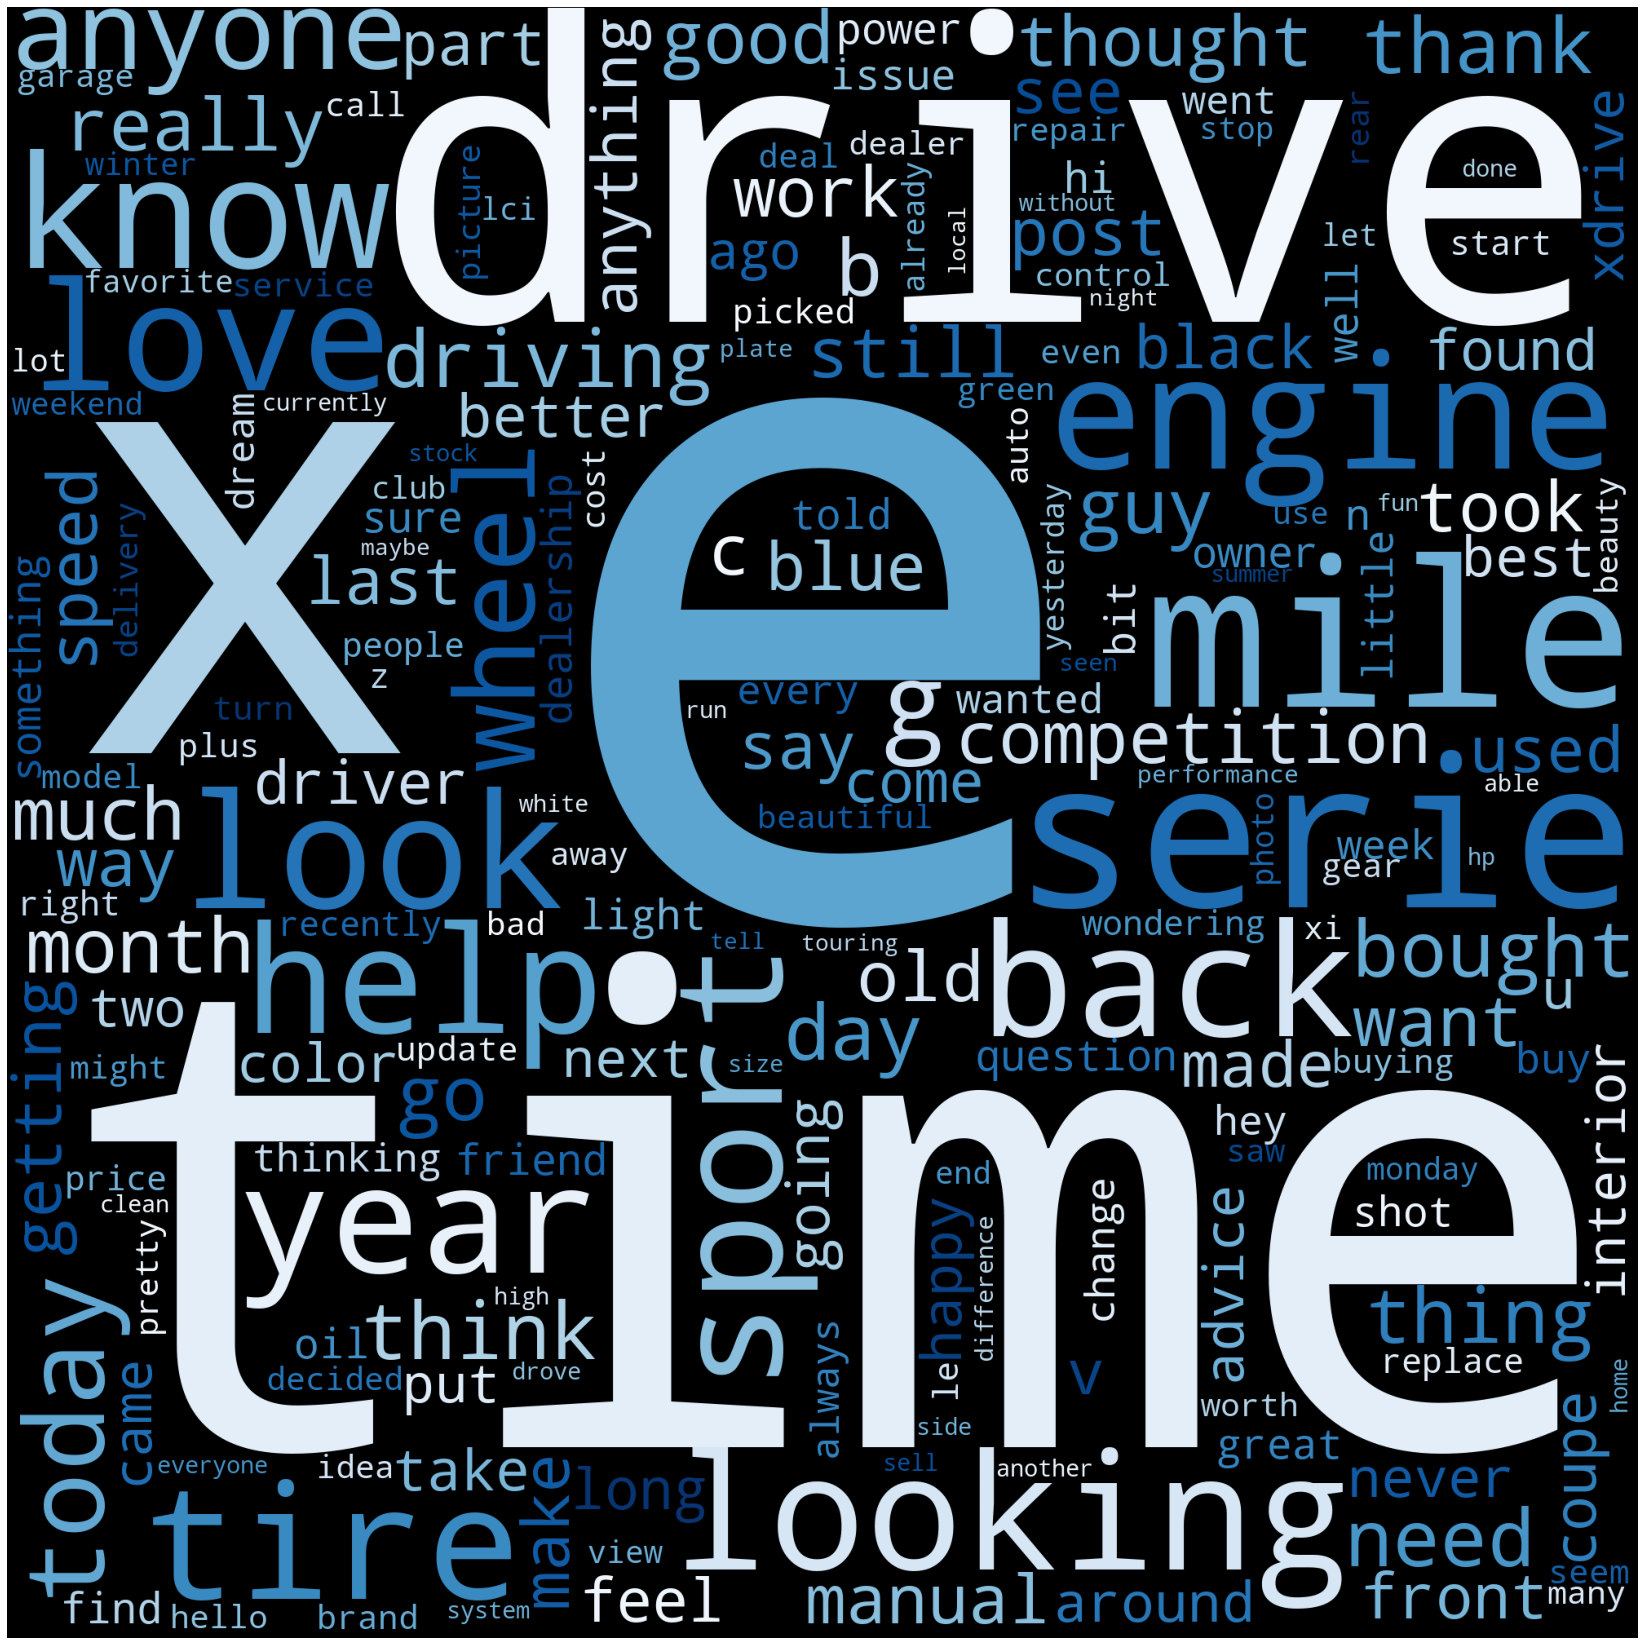

In [28]:
wordcloud_bmw = WordCloud(width = 2000,
                          height = 2000,
                          random_state = 18,                
                          background_color = 'black',
                          colormap = 'Blues_r',
                          collocations = False).generate(" ".join(set(bmwdf['cleaned'])))
plot_cloud(wordcloud_bmw)

In [29]:
#plotting on cleaned text for tsla dataframe
tsladf['cleaned'] = tsladf.apply(lambda row: 
                                 clean_text(row['selftext_title'], 
                                            words_to_remove), axis=1)

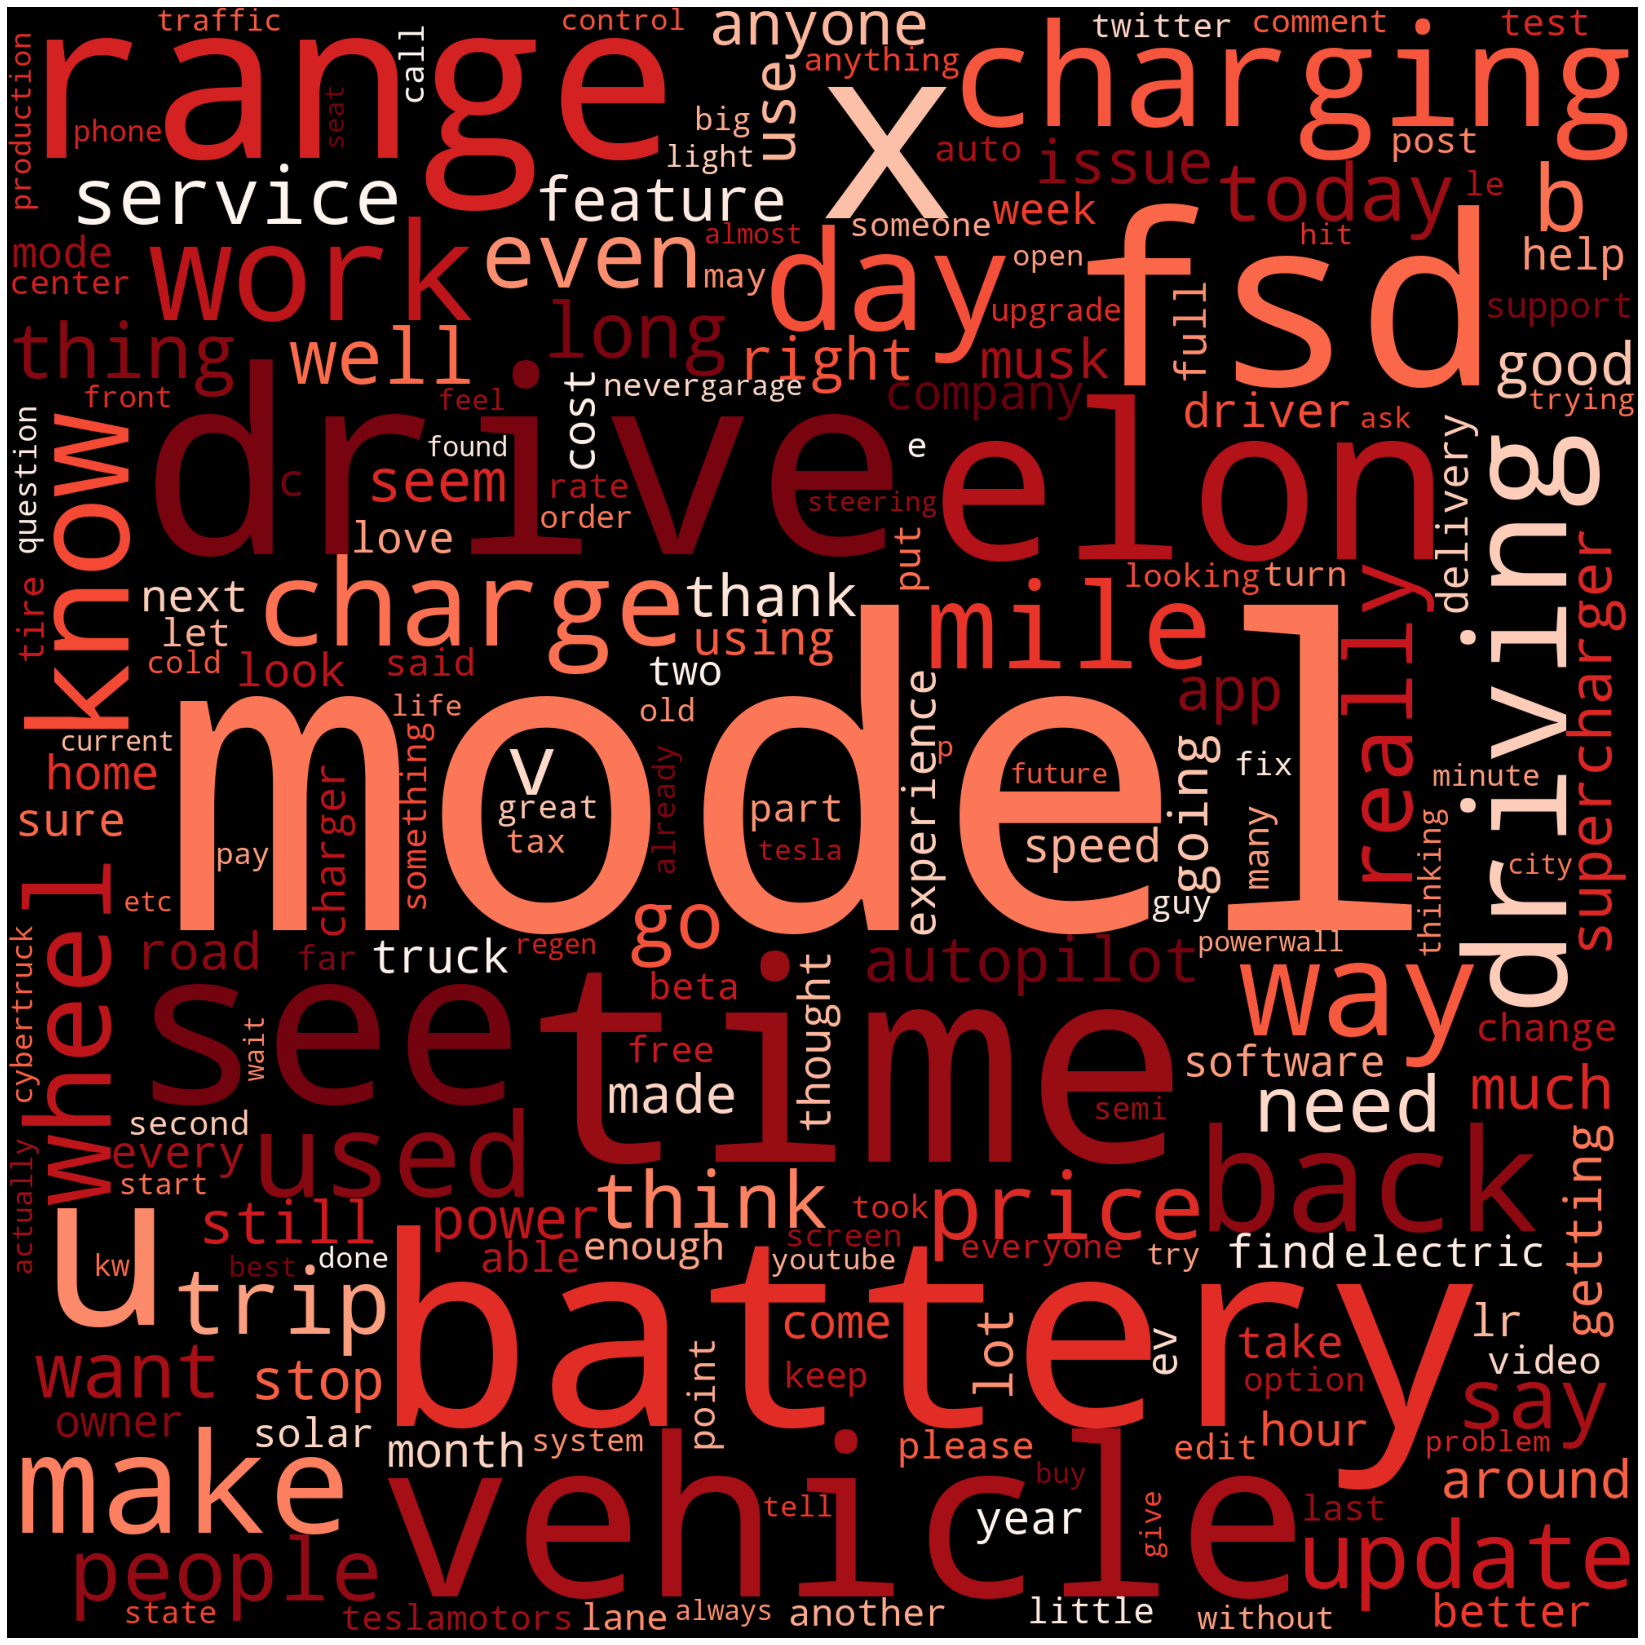

In [30]:
wordcloud_tsla = WordCloud(width = 2000,
                           height = 2000,
                           random_state = 18, 
                           background_color='black',
                           colormap='Reds', 
                           collocations=False).generate(" ".join(set(tsladf['cleaned'])))

plot_cloud(wordcloud_tsla)

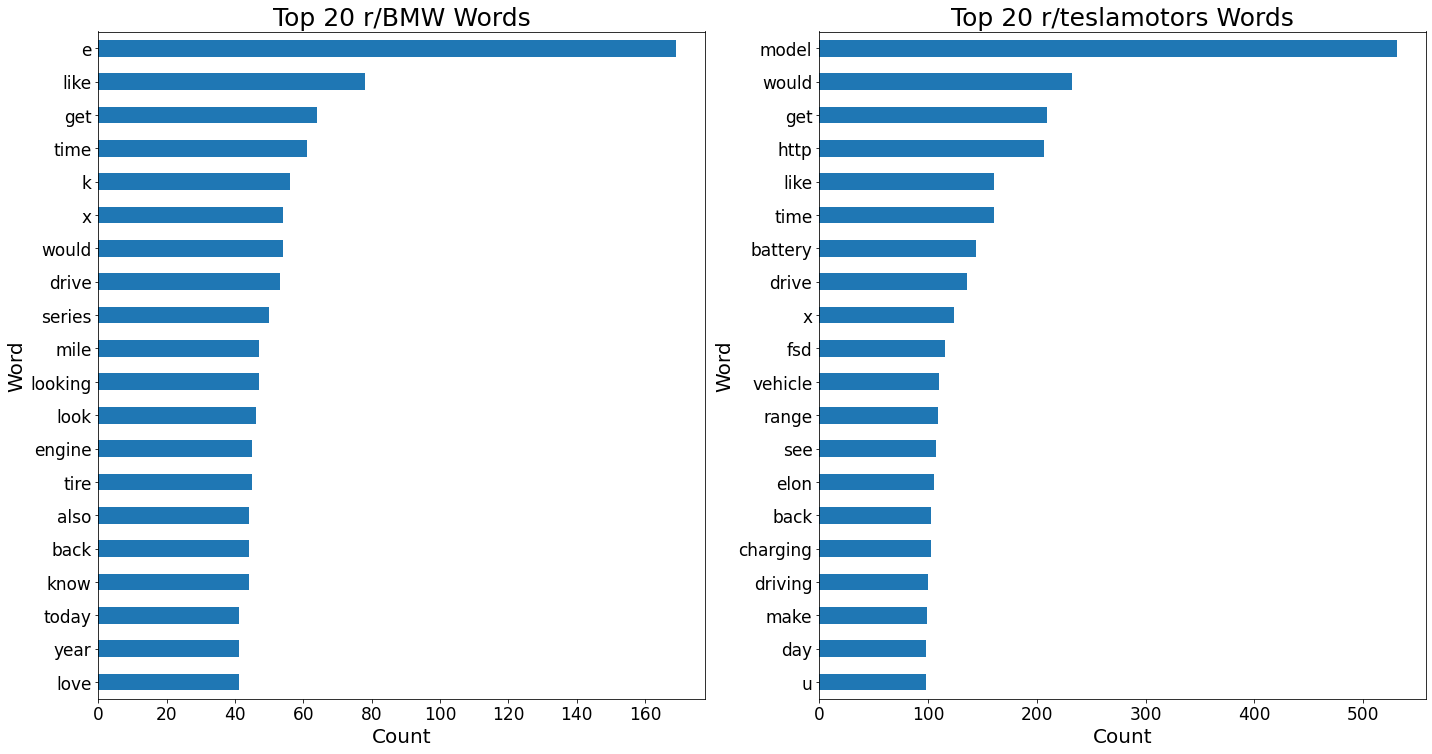

In [31]:
#cvec & tvec by default do not take in single characters
#need to include a regex to include single characters

cvec = CountVectorizer(analyzer = "word",
                             token_pattern = '[\w]+') 

#retrieving words from cvec from bmwdf & assigning to new dataframe
bmw_words_df = pd.DataFrame(cvec.fit_transform(bmwdf['cleaned']).todense(),
                       columns=cvec.get_feature_names())
bmw_count_df = bmw_words_df.sum(axis=0)


#retrieving words from cvec from tsladf & assigning to new dataframe
tsla_words_df = pd.DataFrame(cvec.fit_transform(tsladf['cleaned']).todense(),
                       columns=cvec.get_feature_names())
tsla_count_df = tsla_words_df.sum(axis=0)


plt.figure(figsize=(20,20))

#plotting top 20 words for BMW
plt.subplot(2,2,1)
bmw_count_df.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 r/BMW Words',size=25)
plt.xlabel('Count',size=20)
plt.ylabel('Word',size=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

#plotting top 20 words for TSLA
plt.subplot(2,2,2)
tsla_count_df.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 r/teslamotors Words',size=25)
plt.xlabel('Count',size=20)
plt.ylabel('Word',size=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

plt.tight_layout()

The top words for BMW & Teslamotors are both model specific, for BMW - 'E' (i.e. E30, E81 etc), for Tesla - Model X, Model S etc.

Subsequent words are common words used in regular text. "Drive" and "X" are almost as common in both BMW (xDrive for their All-Wheel Drive models) and Tesla (model X). Other words common in BMW are mostly performance/engine related, whereas with Tesla are mostly Battery/Electric Components related.

## <b>3. MODELLING</b>

Primary models that will be used here are:

    - Logistic Regression with CVEC & TVEC
    - Naives Bayes with CVEC & TVEC
    - AdaBoostClassifier with CVEC & TVEC (DecisionTreesClassifier as 
      base)
    - DecisionTreesClassifier + Bagging with CVEC & TVEC
    
    
Assumptions we will be working with: 

    - That we will use LogisticRegression as our baseline model
    - That LogisticRegression is best suited for Binary Problems, 
      assuming that correlations among predictors are low (although 
      overfitting may occur)

In [32]:
X = df['cleaned']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,                                                
                                                    test_size = 0.25,
                                                    random_state = 18,
                                                    stratify=y #to ensure equal distribution across classes
                                                   )

In [33]:
X.shape

(2347,)

In [34]:
#checking if distributions are equal across classes
print(y_train.value_counts())
print(y_test.value_counts())

0    898
1    862
Name: subreddit, dtype: int64
0    300
1    287
Name: subreddit, dtype: int64


### <b>LOGISTIC REGRESSION</b>

BASELINE SCORE

In [35]:
lr_base_pipe = Pipeline(steps=[('cvec',
                                CountVectorizer()),
                               ('lr',
                                LogisticRegression(
                                    solver='lbfgs',
                                    random_state=18)
                               )])

In [36]:
lr_base_pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()),
                ('lr', LogisticRegression(random_state=18))])

In [37]:
lr_base_pipe.score(X_train, y_train)

0.9636363636363636

In [38]:
lr_base_pipe.score(X_test, y_test)

0.8568994889267462

### Logreg Using CountVectorizer:

In [39]:
lr_cvec_pipe = Pipeline(steps=[('cvec',
                                CountVectorizer()),
                               ('lr',
                                LogisticRegression(
                                    solver='lbfgs',
                                    random_state=18)
                               )])

In [40]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 1400, 1600, 1800
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: None, as we kept hitting lower boundaries
# search the best regularization C

lr_cvec_pipe_params = {'cvec__max_features':[1600, 1800, 2000], #adjust params until optimal features are in between my range
                       'cvec__min_df':[2, 3],
                       'cvec__ngram_range':[(1,1),(1,2)],
                       'lr__C':[0.7, 0.8, 0.9]
              }


In [41]:
#lr_cvec_pipe.get_params()

lr_cvec_grid = GridSearchCV(lr_cvec_pipe,
                  lr_cvec_pipe_params,
                  cv=5
                 )

In [42]:
lr_cvec_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(random_state=18))]),
             param_grid={'cvec__max_features': [1600, 1800, 2000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'lr__C': [0.7, 0.8, 0.9]})

In [43]:
lr_cvec_grid.best_params_

{'cvec__max_features': 1800,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'lr__C': 0.8}

In [44]:
lr_cvec_grid.best_score_

0.8102272727272728

In [45]:
lr_cvec_model = lr_cvec_grid.best_estimator_

In [46]:
lr_cvec_model.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer(max_features=1800, min_df=3)),
                ('lr', LogisticRegression(C=0.8, random_state=18))])

True Negatives: 287
False Positives: 13
False Negatives: 71
True Positives: 216


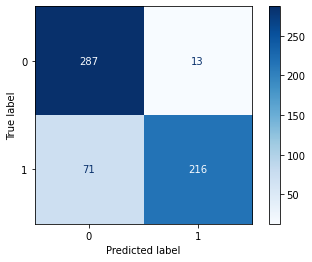

In [47]:
#generating predictions using logreg CVEC model:
lr_cvec_pred = lr_cvec_model.predict(X_test)

#plotting confusion matrix:
tn_lr_cvec, fp_lr_cvec, fn_lr_cvec, tp_lr_cvec = confusion_matrix(y_test, lr_cvec_pred).ravel()

plot_confusion_matrix(lr_cvec_model, 
                      X_test, 
                      y_test,
                      cmap='Blues',
                      values_format='d');

print("True Negatives: %s" % tn_lr_cvec)
print("False Positives: %s" % fp_lr_cvec)
print("False Negatives: %s" % fn_lr_cvec)
print("True Positives: %s" % tp_lr_cvec)

In [48]:
print("CVEC train score on fitted optimal features: ",lr_cvec_model.score(X_train, y_train))
print("CVEC test score on fitted optimal features: ",lr_cvec_model.score(X_test, y_test))

CVEC train score on fitted optimal features:  0.9318181818181818
CVEC test score on fitted optimal features:  0.8568994889267462


### Logreg Using TfidfVectorizer:

In [49]:
lr_tvec_pipe = Pipeline(steps=[('tvec',
                  TfidfVectorizer()),
                 ('lr',
                  LogisticRegression(solver='lbfgs',random_state = 18))                 
    ])

In [50]:
#adjust params until optimal features are in between my range
lr_tvec_params = {'tvec__max_features':[1200, 1400, 1600],
                  'tvec__min_df':[2, 3],
                  'tvec__ngram_range':[(1,1),(1,2)],
                  'lr__C':[0.85, 0.9, 0.95]
              } 

In [51]:
lr_tvec_grid = GridSearchCV(lr_tvec_pipe,
                            lr_tvec_params,
                            cv=5
                           )
lr_tvec_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(random_state=18))]),
             param_grid={'lr__C': [0.85, 0.9, 0.95],
                         'tvec__max_features': [1200, 1400, 1600],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [52]:
lr_tvec_grid.best_params_

{'lr__C': 0.9,
 'tvec__max_features': 1400,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1)}

In [53]:
lr_tvec_model = lr_tvec_grid.best_estimator_

In [54]:
lr_tvec_model.score(X_train, y_train)

0.9107954545454545

True Negatives: 288
False Positives: 12
False Negatives: 61
True Positives: 226


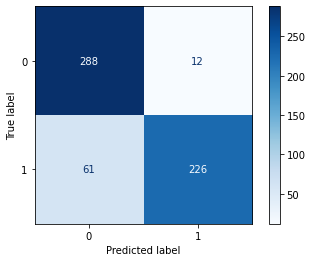

In [55]:
#generating predictions using logreg CVEC model:
lr_tvec_pred = lr_tvec_model.predict(X_test)

#plotting confusion matrix:
tn_lr_tvec, fp_lr_tvec, fn_lr_tvec, tp_lr_tvec = confusion_matrix(y_test, lr_tvec_pred).ravel()

plot_confusion_matrix(lr_tvec_model, 
                      X_test, 
                      y_test,
                      cmap='Blues',
                      values_format='d');

print("True Negatives: %s" % tn_lr_tvec)
print("False Positives: %s" % fp_lr_tvec)
print("False Negatives: %s" % fn_lr_tvec)
print("True Positives: %s" % tp_lr_tvec)

In [56]:
print("TVEC train score on fitted optimal features: ", lr_tvec_model.score(X_train, y_train))
print("TVEC test score on fitted optimal features: ", lr_tvec_model.score(X_test, y_test))

TVEC train score on fitted optimal features:  0.9107954545454545
TVEC test score on fitted optimal features:  0.8756388415672913


### <b>NAIVE BAYES</b>:

In [57]:
from sklearn.metrics import plot_confusion_matrix

### NB Using CountVectorizer:

In [58]:
nb_cvec_pipe = Pipeline([('cvec',
                  CountVectorizer()),
                 ('nbayes',
                  MultinomialNB())                 
    ])

In [59]:
#nb_cvec_pipe.get_params()

In [60]:
nb_cvec_params = {'cvec__max_features': [2000, 3000, 4000],
                  'cvec__min_df':[2, 3],
                  'cvec__ngram_range':[(1,1),(1,2)],
                  'nbayes__alpha':[0.1, 0.2, 0.3]
              }

In [61]:
nb_cvec_grid = GridSearchCV(nb_cvec_pipe,
                  nb_cvec_params,
                  cv=5
                 )

In [62]:
nb_cvec_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nbayes', MultinomialNB())]),
             param_grid={'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'nbayes__alpha': [0.1, 0.2, 0.3]})

In [63]:
nb_cvec_grid.best_params_

{'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'nbayes__alpha': 0.3}

In [64]:
nb_cvec_model = nb_cvec_grid.best_estimator_

In [65]:
nb_cvec_model.score(X_train, y_train)

0.9034090909090909

In [66]:
nb_cvec_model.score(X_test, y_test)

0.8500851788756388

True Negatives: 248
False Positives: 52
False Negatives: 36
True Positives: 251


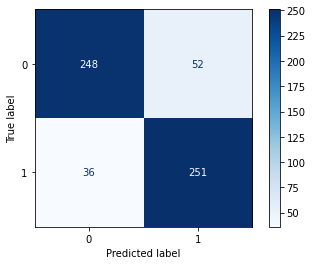

In [67]:
#generating predictions using Naive Bayes CVEC model:
nb_cvec_pred = nb_cvec_model.predict(X_test)

#plotting confusion matrix:
tn_cvec, fp_cvec, fn_cvec, tp_cvec = confusion_matrix(y_test, nb_cvec_pred).ravel()

plot_confusion_matrix(nb_cvec_model, 
                      X_test, 
                      y_test,
                      cmap='Blues',
                      values_format='d');

print("True Negatives: %s" % tn_cvec)
print("False Positives: %s" % fp_cvec)
print("False Negatives: %s" % fn_cvec)
print("True Positives: %s" % tp_cvec)

<b>Checking other metrics for Naive Bayes CVEC model:</b>

In [68]:
#calculating other metrics:
nb_cvec_accuracy = (tp_cvec+tn_cvec)/(tp_cvec+fp_cvec+tn_cvec+fn_cvec)
nb_cvec_misclassification = 1-nb_cvec_accuracy
nb_cvec_sensitivity = tp_cvec/(tp_cvec+fn_cvec)
nb_cvec_specificity = tn_cvec/(tn_cvec+fp_cvec)
nb_cvec_precision = tp_cvec/(tp_cvec+fp_cvec)

In [69]:
print("Accuracy Rate: ", nb_cvec_accuracy)
print("Misclassification rate: ",nb_cvec_misclassification)
print("Sensitivity (True Positive) Rate: ", nb_cvec_sensitivity)
print("Specificity (True Negative) Rate: ", nb_cvec_specificity)
print("Precision Rate: ", nb_cvec_precision)

Accuracy Rate:  0.8500851788756388
Misclassification rate:  0.14991482112436116
Sensitivity (True Positive) Rate:  0.8745644599303136
Specificity (True Negative) Rate:  0.8266666666666667
Precision Rate:  0.8283828382838284


In [70]:
print("NB-CVEC train score on fitted optimal features: ",
      nb_cvec_model.score(X_train, y_train))

print("NB-CVEC test score on fitted optimal features: ",
      nb_cvec_model.score(X_test, y_test))

NB-CVEC train score on fitted optimal features:  0.9034090909090909
NB-CVEC test score on fitted optimal features:  0.8500851788756388


### NB Using TfidfVectorizer:

In [71]:
nb_tvec_pipe = Pipeline(steps=[('tvec',
                               TfidfVectorizer()),
                               ('nbayes',
                               MultinomialNB())
                              ])

In [72]:
nb_tvec_params = {'tvec__max_features': [2000, 3000, 4000],
                  'tvec__min_df':[2, 3, 4],
                  'tvec__ngram_range':[(1,1),(1,2)],
                  'nbayes__alpha':[0.5, 0.6, 0.7]
              }

In [73]:
nb_tvec_grid = GridSearchCV(nb_tvec_pipe,
                  nb_tvec_params,
                  cv=5
                 )

In [74]:
nb_tvec_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nbayes', MultinomialNB())]),
             param_grid={'nbayes__alpha': [0.5, 0.6, 0.7],
                         'tvec__max_features': [2000, 3000, 4000],
                         'tvec__min_df': [2, 3, 4],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [75]:
nb_tvec_grid.best_params_

{'nbayes__alpha': 0.6,
 'tvec__max_features': 3000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [76]:
nb_tvec_grid.score(X_train, y_train)

0.9397727272727273

In [77]:
nb_tvec_model = nb_tvec_grid.best_estimator_

True Negatives: 261
False Positives: 39
False Negatives: 44
True Positives: 243


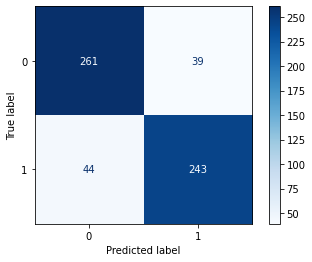

In [78]:
#generating predictions using Naive Bayes CVEC model:
nb_tvec_pred = nb_tvec_grid.predict(X_test)

#plotting confusion matrix:
tn_tvec, fp_tvec, fn_tvec, tp_tvec = confusion_matrix(y_test, nb_tvec_pred).ravel()

plot_confusion_matrix(nb_tvec_model, 
                      X_test, 
                      y_test,
                      cmap='Blues',
                      values_format='d');

print("True Negatives: %s" % tn_tvec)
print("False Positives: %s" % fp_tvec)
print("False Negatives: %s" % fn_tvec)
print("True Positives: %s" % tp_tvec)

<b>Checking other metrics for Naive Bayes TVEC model:</b>

In [79]:
nb_tvec_accuracy = (tp_tvec+tn_tvec)/(tp_tvec+fp_tvec+tn_tvec+fn_tvec)
nb_tvec_misclassification = 1- nb_tvec_accuracy
nb_tvec_sensitivity = tp_tvec/(tp_tvec+fn_tvec)
nb_tvec_specificity = tn_tvec/(tn_tvec+fp_tvec)
nb_tvec_precision = tp_tvec/(tp_tvec+fp_tvec)

In [80]:
print("Accuracy Rate: ", nb_tvec_accuracy)
print("Misclassification rate: ",nb_tvec_misclassification)
print("Sensitivity (True Positive) Rate: ", nb_tvec_sensitivity)
print("Specificity (True Negative) Rate: ", nb_tvec_specificity)
print("Precision Rate: ", nb_tvec_precision)

Accuracy Rate:  0.858603066439523
Misclassification rate:  0.141396933560477
Sensitivity (True Positive) Rate:  0.8466898954703833
Specificity (True Negative) Rate:  0.87
Precision Rate:  0.8617021276595744


In [81]:
print("NB-TVEC train score on fitted optimal features: ",
      nb_tvec_model.score(X_train,y_train))

print("NB-TVEC test score on fitted optimal features: ",
      nb_tvec_model.score(X_test,y_test))

NB-TVEC train score on fitted optimal features:  0.9397727272727273
NB-TVEC test score on fitted optimal features:  0.858603066439523


### <b>ADABOOST</b>:

### AdaBoost using CountVectorizer:

In [82]:
ada_cvec_pipe = Pipeline(steps=[('cvec',
                  CountVectorizer()),
                 ('ada',
                  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                    random_state = 18))
    ])

In [83]:
ada_cvec_params = {'cvec__max_features': [2000, 3000, 4000],
                   'cvec__min_df':[2, 3],
                   'cvec__ngram_range':[(1,1),(1,2)],
                   'ada__n_estimators':[5, 50, 80],
}

In [84]:
#ada_cvec_pipe.get_params()

In [85]:
ada_cvec_grid = GridSearchCV(ada_cvec_pipe,
                  ada_cvec_params,
                  cv=5
                 )

In [86]:
ada_cvec_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('ada',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                                           random_state=18))]),
             param_grid={'ada__n_estimators': [5, 50, 80],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [87]:
ada_cvec_grid.best_params_

{'ada__n_estimators': 5,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [88]:
ada_cvec_model = ada_cvec_grid.best_estimator_

In [89]:
ada_cvec_model.score(X_train, y_train) #this fits on best estimator, scores on train

0.9931818181818182

In [90]:
ada_cvec_model.score(X_test, y_test) #this fits based on best estimator, scores on test

0.8023850085178875

In [91]:
print("AdaBoost CVEC Train Score:",ada_cvec_model.score(X_train, y_train))
print("AdaBoost CVEC TEST Score:",ada_cvec_model.score(X_test, y_test))


AdaBoost CVEC Train Score: 0.9931818181818182
AdaBoost CVEC TEST Score: 0.8023850085178875


### AdaBoost using TfidfVectorizer:

In [92]:
ada_tvec_pipe = Pipeline(steps=[('tvec',
                  TfidfVectorizer()),
                 ('ada',
                  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                    random_state = 18))
    ])

In [93]:
ada_tvec_params = {'tvec__max_features': [1000, 2000, 3000],
                   'tvec__min_df':[2, 3],
                   'tvec__ngram_range':[(1,1),(1,2)],
                   'ada__n_estimators':[25, 50, 75],
                   'ada__base_estimator__max_depth': [1,2],
                   'ada__learning_rate':[0.4, 0.6, 0.8],
                   'ada__base_estimator__ccp_alpha': [0.2, 0.3, 0.4],
}

In [94]:
ada_tvec_grid = GridSearchCV(ada_tvec_pipe,
                  ada_tvec_params,
                  cv=5
                 )

In [96]:
ada_tvec_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('ada',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                                           random_state=18))]),
             param_grid={'ada__base_estimator__ccp_alpha': [0.2, 0.3, 0.4],
                         'ada__base_estimator__max_depth': [1, 2],
                         'ada__learning_rate': [0.4, 0.6, 0.8],
                         'ada__n_estimators': [25, 50, 75],
                         'tvec__max_features': [1000, 2000, 3000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [97]:
ada_tvec_model = ada_tvec_grid.best_estimator_

In [98]:
ada_tvec_grid.best_params_

{'ada__base_estimator__ccp_alpha': 0.2,
 'ada__base_estimator__max_depth': 1,
 'ada__learning_rate': 0.4,
 'ada__n_estimators': 25,
 'tvec__max_features': 1000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

In [99]:
ada_tvec_model.score(X_train, y_train)

0.5102272727272728

In [100]:
print("AdaBoost TVEC Train Score:",ada_tvec_model.score(X_train, y_train))
print("AdaBoost TVEC TEST Score:",ada_tvec_model.score(X_test, y_test))

AdaBoost TVEC Train Score: 0.5102272727272728
AdaBoost TVEC TEST Score: 0.5110732538330494


### DecisionTree Classifier + Bootstrap Aggregating:

### DTC + Bagging using CountVectorizer

In [101]:
dtc_cvec_pipe = Pipeline([('cvec',
                           CountVectorizer()),
                          ('dtc',
                           BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                            random_state = 18))
                           ])

In [102]:
dtc_cvec_params = {'cvec__max_features': [1000, 2000, 3000, 4000],
                   'cvec__ngram_range':[(1,1),(1,2)],
                   'dtc__base_estimator__min_samples_split': [4, 9, 12],
                   'dtc__base_estimator__min_samples_leaf':[2, 3, 4],
              }

In [103]:
dtc_cvec_grid = GridSearchCV(dtc_cvec_pipe,
                             dtc_cvec_params,
                             cv=5
                            )

In [104]:
dtc_cvec_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('dtc',
                                        BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                                          random_state=18))]),
             param_grid={'cvec__max_features': [1000, 2000, 3000, 4000],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'dtc__base_estimator__min_samples_leaf': [2, 3, 4],
                         'dtc__base_estimator__min_samples_split': [4, 9, 12]})

In [105]:
dtc_cvec_grid.best_params_

{'cvec__max_features': 1000,
 'cvec__ngram_range': (1, 2),
 'dtc__base_estimator__min_samples_leaf': 3,
 'dtc__base_estimator__min_samples_split': 12}

In [106]:
dtc_cvec_model = dtc_cvec_grid.best_estimator_

In [107]:
print("DTC-CVEC Train Score:",dtc_cvec_model.score(X_train, y_train))
print("DTC-CVEC TEST Score:",dtc_cvec_model.score(X_test, y_test))


DTC-CVEC Train Score: 0.8534090909090909
DTC-CVEC TEST Score: 0.8160136286201022


### DTC + Bagging using TfidfVectorizer

In [108]:
dtc_tvec_pipe = Pipeline([('tvec',
                           TfidfVectorizer()),
                          ('dtc',
                           BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                            random_state=18))
                           ])

In [109]:
#dtc_tvec_pipe.get_params()

In [110]:
dtc_tvec_params = {'tvec__max_features': [2000, 3000, 4000],
                   'tvec__ngram_range':[(1,1),(1,2)],
                   'dtc__base_estimator__min_samples_leaf':[2, 4, 6],
              }

In [111]:
dtc_tvec_grid = GridSearchCV(dtc_tvec_pipe,
                             dtc_tvec_params,
                             cv=5
                            )

In [112]:
dtc_tvec_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('dtc',
                                        BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                                          random_state=18))]),
             param_grid={'dtc__base_estimator__min_samples_leaf': [2, 4, 6],
                         'tvec__max_features': [2000, 3000, 4000],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [113]:
dtc_tvec_grid.best_params_

{'dtc__base_estimator__min_samples_leaf': 2,
 'tvec__max_features': 3000,
 'tvec__ngram_range': (1, 1)}

In [114]:
dtc_tvec_model = dtc_tvec_grid.best_estimator_

In [115]:
print("DTC-TVEC Train Score:",dtc_tvec_model.score(X_train, y_train))
print("DTC-TVEC TEST Score:",dtc_tvec_model.score(X_test, y_test))

DTC-TVEC Train Score: 0.9232954545454546
DTC-TVEC TEST Score: 0.8313458262350937


## <b>4. Evaluation & Conceptual Understanding</b>

### <b>Overview:</b>
We initially started with LogReg as our baseline model which achieved a score of 0.8569 prior to optimization.

We will now put all our model scores into a dataframe for a better overview of how the models performed.

In [116]:
train_test_scores = [["LogRegBASE", "CVEC", lr_base_pipe.score(X_train, y_train),
                      lr_cvec_model.score(X_test, y_test)],
                     ["LogRegBASE", "TVEC", lr_base_pipe.score(X_train, y_train), 
                      lr_tvec_model.score(X_test, y_test)],
                     
                      ["LogReg", "CVEC", lr_cvec_model.score(X_train, y_train),
                      lr_cvec_model.score(X_test, y_test)],
                     ["LogReg", "TVEC", lr_tvec_model.score(X_train, y_train), 
                      lr_tvec_model.score(X_test, y_test)],
                     
                     ["NBayes", "CVEC", nb_cvec_model.score(X_train, y_train), 
                      nb_cvec_model.score(X_test, y_test)],
                     ["NBayes", "TVEC", nb_tvec_model.score(X_train, y_train),
                      nb_tvec_model.score(X_test, y_test)],          
                     
                     ["ADABOOST", "CVEC", ada_cvec_model.score(X_train, y_train), 
                      ada_cvec_model.score(X_test, y_test)],
                     ["ADABOOST", "TVEC", ada_tvec_model.score(X_train, y_train), 
                      ada_tvec_model.score(X_test, y_test)],
                     
                     ["Decision Tree + Bagging", "CVEC", dtc_cvec_model.score(X_train, y_train),
                      dtc_cvec_model.score(X_test, y_test)],
                     ["Decision Tree + Bagging", "TVEC", dtc_tvec_model.score(X_train, y_train), 
                      dtc_tvec_model.score(X_test, y_test)]
               ]

In [117]:
scores_df = pd.DataFrame(train_test_scores, columns=['classifier',
                                                    'transformer',
                                                    'train_score',
                                                    'test_score'])

scores_df

,classifier,transformer,train_score,test_score
0,LogRegBASE,CVEC,0.963636,0.856899
1,LogRegBASE,TVEC,0.963636,0.875639
2,LogReg,CVEC,0.931818,0.856899
3,LogReg,TVEC,0.910795,0.875639
4,NBayes,CVEC,0.903409,0.850085
5,NBayes,TVEC,0.939773,0.858603
6,ADABOOST,CVEC,0.993182,0.802385
7,ADABOOST,TVEC,0.510227,0.511073
8,Decision Tree + Bagging,CVEC,0.853409,0.816014
9,Decision Tree + Bagging,TVEC,0.923295,0.831346


If we sort by descending order on test_score, we can see that the model that performed the best on the test set was the combination of LogReg + TVEC:

In [118]:
scores_df.sort_values(by='test_score', ascending=False)

,classifier,transformer,train_score,test_score
1,LogRegBASE,TVEC,0.963636,0.875639
3,LogReg,TVEC,0.910795,0.875639
5,NBayes,TVEC,0.939773,0.858603
0,LogRegBASE,CVEC,0.963636,0.856899
2,LogReg,CVEC,0.931818,0.856899
4,NBayes,CVEC,0.903409,0.850085
9,Decision Tree + Bagging,TVEC,0.923295,0.831346
8,Decision Tree + Bagging,CVEC,0.853409,0.816014
6,ADABOOST,CVEC,0.993182,0.802385
7,ADABOOST,TVEC,0.510227,0.511073


After tuning parameters and achieving above scores, LogReg with TVEC outperformed our baseline model with a test score of 0.875639

### Comparing models using ROC AUC

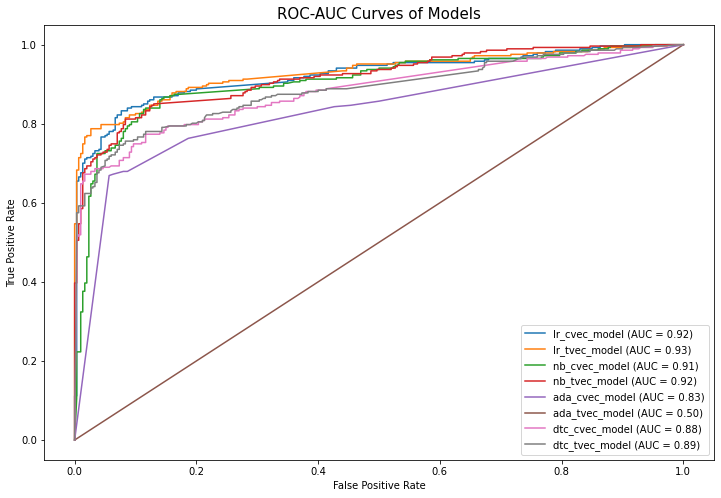

In [119]:
list_of_models = [lr_cvec_model, 
                  lr_tvec_model, 
                  nb_cvec_model, 
                  nb_tvec_model, 
                  ada_cvec_model, 
                  ada_tvec_model, 
                  dtc_cvec_model, 
                  dtc_tvec_model]

list_of_model_names = ["lr_cvec_model", 
                       "lr_tvec_model", 
                       "nb_cvec_model", 
                       "nb_tvec_model", 
                       "ada_cvec_model", 
                       "ada_tvec_model", 
                       "dtc_cvec_model", 
                       "dtc_tvec_model"]

plt.figure(figsize=(12,8))
ax = plt.gca()
for model, model_name in zip(list_of_models, list_of_model_names):
    plot_roc_curve(model, X_test, y_test, name=model_name, ax=ax)
plt.title('ROC-AUC Curves of Models', fontsize=15);

The top 5 models are quite close in terms of AUC score, apart from ADA-TVEC which has an AUC of 0.50.

### <b>Examining Classification Metrics:</b>

True Negatives: 288
False Positives: 12
False Negatives: 61
True Positives: 226 

Accuracy Rate:  0.8756388415672913
Misclassification rate:  0.12436115843270867
Sensitivity (True Positive) Rate:  0.7874564459930313
Specificity (True Negative) Rate:  0.96
Precision Rate:  0.9495798319327731


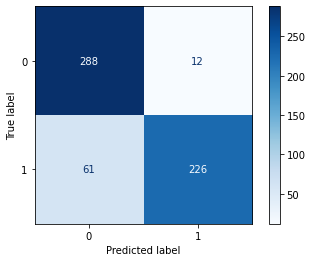

In [120]:
#generating predictions using logreg CVEC model:
lr_tvec_pred = lr_tvec_model.predict(X_test)

#plotting confusion matrix:
tn_lr_tvec, fp_lr_tvec, fn_lr_tvec, tp_lr_tvec = confusion_matrix(y_test, lr_tvec_pred).ravel()

plot_confusion_matrix(lr_tvec_model, 
                      X_test, 
                      y_test,
                      cmap='Blues',
                      values_format='d');

print("True Negatives: %s" % tn_lr_tvec)
print("False Positives: %s" % fp_lr_tvec)
print("False Negatives: %s" % fn_lr_tvec)
print("True Positives: %s" % tp_lr_tvec,"\n")

#formulas for other classification metrics
lr_tvec_accuracy = (tp_lr_tvec + tn_lr_tvec)/(tp_lr_tvec + fp_lr_tvec + tn_lr_tvec + fn_lr_tvec)
lr_tvec_misclassification = 1 - lr_tvec_accuracy
lr_tvec_sensitivity = tp_lr_tvec/(tp_lr_tvec + fn_lr_tvec)
lr_tvec_specificity = tn_lr_tvec/(tn_lr_tvec + fp_lr_tvec)
lr_tvec_precision = tp_lr_tvec/(tp_lr_tvec + fp_lr_tvec)

print("Accuracy Rate: ", lr_tvec_accuracy)
print("Misclassification rate: ", lr_tvec_misclassification)
print("Sensitivity (True Positive) Rate: ", lr_tvec_sensitivity)
print("Specificity (True Negative) Rate: ", lr_tvec_specificity)
print("Precision Rate: ", lr_tvec_precision)

The percentage of observations that were predicted correctly on our teset set was <b>87.56% (Accuracy Rate)</b>, while the percentage of observations incorrectly predicted was <b>12.44%</b>.

Among those predicted to be an r/tesla post, <b>78.74% (sensitivity)</b> were correctly classified.

Among those predicted to be an r/BMW post, <b>96% (specificity)</b> were correctly classified.

Among those predicted to be an r/teslamotors post, <b>94.96% (precision rate)</b> were correctly classified.

r/BMW posts were more likely to be misclassified than r/teslamotors, presumably due to the reason that posts made in r/BMW has less BMW-specific discussions. r/teslamotors on the other hand had very specific words that stood out that were related to Electric Vehicle (EV) discussions.

### <b>Features(words) with large absolute coefficients:</b>

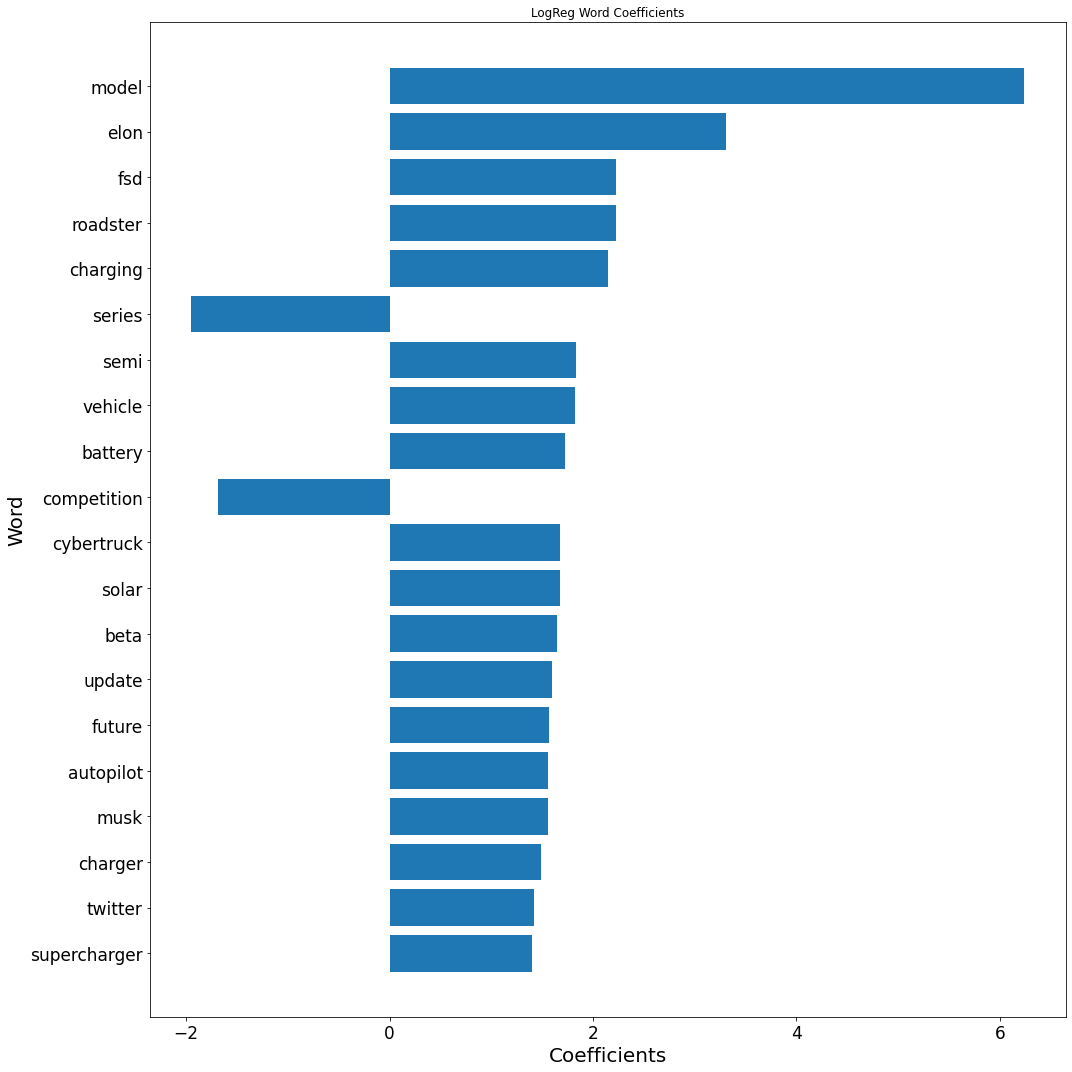

In [121]:
#extracting list of feature names from our best model
lr_tvec_features = lr_tvec_model.named_steps.tvec.get_feature_names()

#extracting coefficients from our best model
lr_tvec_coefs = lr_tvec_model.named_steps.lr.coef_[0]

#assigning to a dataframe
lr_tvec_coef_df = pd.DataFrame(zip(lr_tvec_features, lr_tvec_coefs), 
                               columns=['features', 'coefs'])
#sort by magnitude
lr_tvec_coef_df.sort_values(by='coefs',
                            ascending=True, 
                            key=abs,
                            inplace=True)

#selecting and plotting the top 20
plt.figure(figsize=(15,15), facecolor='white')
plt.barh(lr_tvec_coef_df['features'].tail(20), lr_tvec_coef_df['coefs'].tail(20))
plt.title('LogReg Word Coefficients')
plt.xlabel('Coefficients',size=20)
plt.ylabel('Word',size=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

plt.tight_layout()

In the above chart we have an overall visualisation of which words had the biggest weightage in our models. Negative coefficients are indicative of words predictive of r/BMW, while positive coefficients are indicative of words predictive of r/teslamotors.

It is evident that more words are specific to r/teslamotors than r/BMW. Keywords for r/BMW are specific to the "model" aspect of the brand, such as competition and series. 

### A closer look at misclassified posts:

In [122]:
# From LOGREG - TVEC:
# Examining incorrectly classified posts - 
df_lr_tvec_pred = pd.DataFrame({
    'X_test': X_test,
    'y_test': y_test,
    'y_pred': lr_tvec_pred
})

# Posts incorrectly predicted:
for i in df_lr_tvec_pred[(df_lr_tvec_pred['y_test'] - df_lr_tvec_pred['y_pred'])!=0]['X_test']:
    print("-",i,"\n")

- csi delivered 

- hi taken delivery want use work android phone phone text message personal apple phone music apps etc possible want cable connection thanks advance two phone query 

- weird crash crashed every crash crash 

- came across cheeky license plate today 

- report contributed billion california economy supported job last 

- wonderful voice command seat heater naughty language warning 

- ron perlman legendary answer question garage 

- mar rover 

- funding secured 

- red today store 

- streetlight flash properly distinguish arrow circle 

- beaut clark 

- taxi amsterdam 

- big hero xy 

- without doubt favorite feature 

- thing 

- competition coming 

- covid canceled wedding nc opted mile road trip elope grand teton nat l park wy instead 

- teardown find electronics year ahead toyota vw 

- dealing heatwave netherlands 

- expecting monday commute x post teslacam 

- week mod making poll hope partake starting simple keeping poll wiki page anyone want see later p

Above, we take a closer look at the posts that have been misclassified.<br>

We can see that these posts very generally pertain to automotive talk and would very easily be misclassified along with other subreddits such as r/cartalk and r/cars, which were not a part of this classification problem.<br>

These are posts that lack context/sufficient text and would be difficult to classify even for a person who frequents these subs to classify without more context or the presence of media.

## <b>5. Conclusions & Recommendations</b>

In [123]:
scores_df.sort_values(by='test_score', ascending=False).head(4)

,classifier,transformer,train_score,test_score
1,LogRegBASE,TVEC,0.963636,0.875639
3,LogReg,TVEC,0.910795,0.875639
5,NBayes,TVEC,0.939773,0.858603
0,LogRegBASE,CVEC,0.963636,0.856899


<b>Shortcomings</b>:<br>
It was not taken into account that the default CountVectorizer and TfidfVectorizer does not take into single characters as words, and therefore single characters that were prominent in across r/BMW and r/teslamotors were not accounted for in our models. This may have affected the models' performances.

<b>Conclusions</b>:<br>
Aside from our LogReg - TVEC model, we can see that in general, Logistic Regression and Multinomial Naive Bayes models have performed quite closely to our chosen model, with accuracy scores hovering around 85%, although the latter 3 have a stronger case of overfitting.

We can maintain that Logistic Regression is best suited for this binary classification case.

While it may be difficult to improve our scores for the classification of two highly similar topics, accuracy may be improved if we include a list of specific BMW/Tesla model numbers and names.

Since both subreddits are media-heavy, it may be a good idea to scrape comments as well.
